In [1]:
import pyam
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

<IPython.core.display.Javascript object>

Step 1: Read in the compiled CDR dataset.

In [2]:
df = pyam.IamDataFrame(
    Path(
        '../data/101_data.xlsx'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/101_data.xlsx
pyam.core - INFO: Reading meta indicators


Step 2: Read in the filter sets for bioenergy (PE)

In [3]:
filter_set = pd.read_csv(
    Path(
        '../data/103_filter_set_bio.csv'
    ),
    index_col=[0,1]
)

In [4]:
filter_set_small = (
    filter_set
    .loc[df.meta.index.intersection(filter_set.index)]
)

In [5]:
df.set_meta(
    meta=False,
    name='bio_sustainable'
)

In [6]:
df.set_meta(
    meta=True,
    name='bio_sustainable',
    index=filter_set_small[filter_set_small['bio_sustainable']==True].index
)

In [7]:
df.set_meta(
    meta=filter_set_small['pe_bio_max'],
    name='pe_bio_max'
)

Step 3: For each world region, calculate the cumulative land and novel CDR over two time periods:
* 2020 to global net zero CO2
* Global net zero CO2 to 2100

In [8]:
netzero_year = df.meta.loc[:, 'Year of netzero CO2 emissions (Harm-Infilled) table']

In [9]:
netzero_year.fillna(2100, inplace=True)

In [10]:
novel_cdr = 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Non-Land'
conventional_cdr = 'AR6 Reanalysis|OSCARv3.2|Carbon Removal|Land'

In [11]:
for reg in df.region:
    if reg == 'World':
        continue
    for var in [novel_cdr, conventional_cdr]:
        if var == novel_cdr:
            meta_prefix = 'novel_cdr'
        else:
            meta_prefix = 'conventional_cdr'
        ts_data = (
            df
            .filter(
                region=reg,
                variable=var
            )
            .timeseries()
        )
        # The cumulative estimate to net zero
        df.set_meta(
            meta=ts_data.apply(
               lambda x: pyam.cumulative(
                   x,
                   first_year=2020,
                   last_year=netzero_year[x.name[0:2]]
               ),
               axis=1
            ),
            name=f'{meta_prefix}_{reg}_2020_netzero'
        )
        # The cumulative estimate to 2100
        df.set_meta(
            meta=ts_data.apply(
                lambda x: pyam.cumulative(
                    x,
                    first_year=netzero_year[x.name[0:2]],
                    last_year=2100
                ),
                axis=1
            ),
            name=f'{meta_prefix}_{reg}_netzero_2100'
        )

Step 4: Now, let us cut the bioenergy pe into a couple of bins.

In [12]:
region_to_assess = 'R5ASIA'

In [13]:
bins_for_pe = (
    pd
    .IntervalIndex
    .from_tuples(
        [
            (0, 100),
            (100, 300),
            (300, 500)
        ]
    )
)
bin_maps = dict(
    zip(
        bins_for_pe,
        [
            '0-100',
            '100-300',
            '300-500'
        ]
    )
)

In [14]:
df.meta.loc[:, 'category_pe'] = (
    pd.cut(
        df.meta.loc[:, 'pe_bio_max'],
        bins=bins_for_pe
    )
    .map(bin_maps)
)

Further format the data so that we can make quick plots to compare stuff.

In [15]:
cols_to_melt = [
    x for x in df.meta.columns if 'novel_cdr' in x or 'conventional_cdr' in x
]

In [16]:
melted_data = (
    pd.melt(
        frame=df.meta.reset_index(),
        id_vars=['model', 'scenario', 'Category', 'category_pe'],
        value_vars=cols_to_melt
    )
)

In [17]:
melted_data['variable'] = melted_data['variable'].apply(
    lambda x: x.replace('cdr', 'cdr_World') if 'R5' not in x else x
)

In [18]:
melted_data.loc[:, 'cdr_type'] = melted_data['variable'].apply(
    lambda x: x.split('_')[0] + '_' + x.split('_')[1]
)
melted_data.loc[:, 'region'] = melted_data['variable'].apply(
    lambda x: x.split('_')[2]
)
melted_data.loc[:, 'timeframe'] = melted_data['variable'].apply(
    lambda x: x.split('_')[3] + '_' + x.split('_')[4]
)

In [19]:
melted_data = melted_data[melted_data['region']!='World']

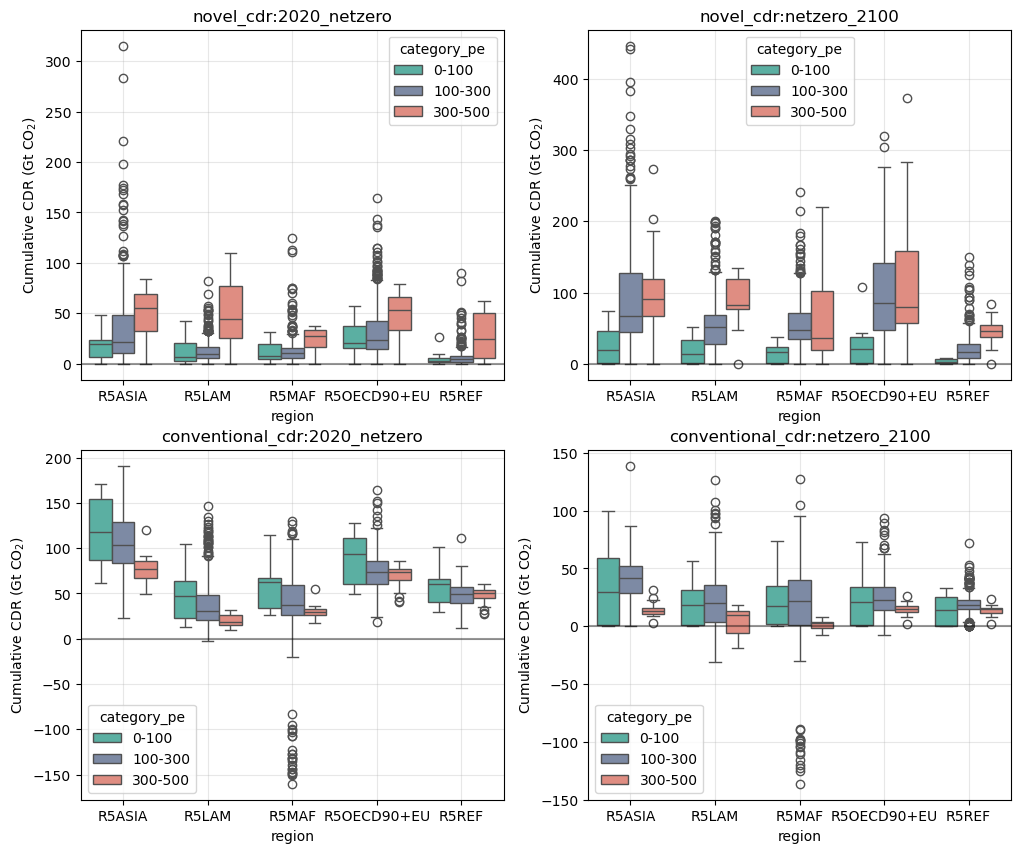

In [20]:
fig, ax = plt.subplots(2,2,figsize=(12,10))

for i, cdr_type in enumerate(['novel_cdr', 'conventional_cdr']):
    for j, timeframe in enumerate(['2020_netzero', 'netzero_2100']):
        sns.boxplot(
            data=melted_data[
                (melted_data['cdr_type']==cdr_type) &
                (melted_data['timeframe']==timeframe)
            ],
            x='region',
            y='value',
            hue='category_pe',
            palette=['#4dbdab', '#7688ab', '#ee8172'],
            ax=ax[i,j],
        )
        ax[i,j].set_title(f'{cdr_type}:{timeframe}')
        ax[i,j].set_ylabel('Cumulative CDR (Gt CO$_2$)')
        ax[i,j].grid(alpha=0.3)
        ax[i,j].axhline(0, color='black', alpha=0.4)

In [21]:
fig.savefig(
    Path(
        'figures/SI_fig2.png'
    ),
    bbox_inches='tight',
    dpi=400
)